Files already downloaded and verified
Files already downloaded and verified


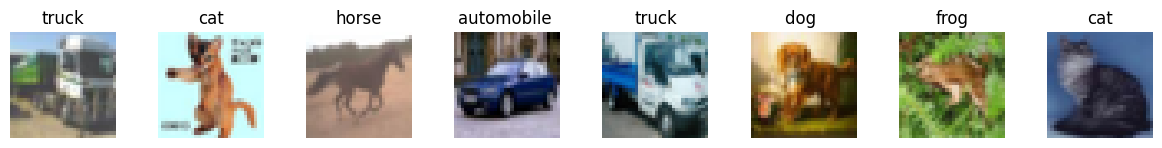

Epoch 1/30 - Loss: 1.5916, Train Acc: 43.38%
Epoch 2/30 - Loss: 1.2779, Train Acc: 55.09%
Epoch 3/30 - Loss: 1.1574, Train Acc: 59.73%
Epoch 4/30 - Loss: 1.0879, Train Acc: 62.08%
Epoch 5/30 - Loss: 1.0337, Train Acc: 64.15%
Epoch 6/30 - Loss: 0.9939, Train Acc: 65.59%
Epoch 7/30 - Loss: 0.9610, Train Acc: 66.86%
Epoch 8/30 - Loss: 0.9317, Train Acc: 67.79%
Epoch 9/30 - Loss: 0.9060, Train Acc: 68.62%
Epoch 10/30 - Loss: 0.8882, Train Acc: 69.35%
Epoch 11/30 - Loss: 0.8676, Train Acc: 70.03%
Epoch 12/30 - Loss: 0.8480, Train Acc: 70.66%
Epoch 13/30 - Loss: 0.8375, Train Acc: 71.03%
Epoch 14/30 - Loss: 0.8238, Train Acc: 71.44%
Epoch 15/30 - Loss: 0.8106, Train Acc: 71.94%
Epoch 16/30 - Loss: 0.7968, Train Acc: 72.18%
Epoch 17/30 - Loss: 0.7869, Train Acc: 72.61%
Epoch 18/30 - Loss: 0.7795, Train Acc: 72.98%
Epoch 19/30 - Loss: 0.7688, Train Acc: 73.18%
Epoch 20/30 - Loss: 0.7601, Train Acc: 73.61%
Epoch 21/30 - Loss: 0.7495, Train Acc: 74.13%
Epoch 22/30 - Loss: 0.7436, Train Acc: 74.2

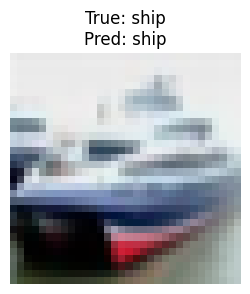

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# 1. DATA SETUP
# ============================================================================

RESIZE_DIMS = (32, 32)
DATA_ROOT = './data'
BATCH_SIZE = 64
CIFAR10_LABELS  = [
    'airplane ', 'automobile ', 'bird ', 'cat', 'deer',
    'dog ', 'frog', 'horse', 'ship', 'truck'
]

# Create transforms and dataloaders
transform = transforms.Compose([
    transforms.Resize(RESIZE_DIMS),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=True, transform=transform, download=True
)
val_dataset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# ============================================================================
# 2. VISUALIZATION UTILITIES
# ============================================================================

def show_images_grid(imgs, nrows, ncols, titles=None, scale=1.5):
    """Display a grid of images."""
    imgs = imgs.cpu().numpy()
    
    # Transpose from (C, H, W) to (H, W, C) for RGB display
    if imgs.ndim == 4 and imgs.shape[1] == 3:
        imgs = np.transpose(imgs, (0, 2, 3, 1))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * scale, nrows * scale))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(imgs):
            ax.imshow(imgs[i])  
            if titles:
                ax.set_title(titles[i])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize first batch
X, y = next(iter(train_loader))
batch_labels = [CIFAR10_LABELS[int(label)] for label in y[:8]]
show_images_grid(X[:8], 1, 8, titles=batch_labels)






# ============================================================================
# 3. Basic CNN Model
# ============================================================================

class MinimalisticCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MinimalisticCNN, self).__init__()
        # First convolutional block
        # Input: (batch_size, 1, 28, 28) assuming grayscale 28x28 images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Output after conv1: (batch_size, 16, 28, 28)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output after pool1: (batch_size, 16, 14, 14)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Output after conv2: (batch_size, 32, 14, 14)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output after pool2: (batch_size, 32, 7, 7)

        # Fully connected layer
        # Calculate the input features for the linear layer: 32 channels * 7 * 7 spatial dimensions
        self.fc = nn.Linear(32 * 8 * 8, num_classes)

    def forward(self, x):
        # Apply first convolutional block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Apply second convolutional block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten the output for the fully connected layer
        # The -1 tells PyTorch to infer the batch size
        x = x.view(x.size(0), -1)

        # Apply fully connected layer
        x = self.fc(x)
        return x

# ============================================================================
# 4. Model Training
# ============================================================================

model = MinimalisticCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    losses.append(avg_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")

# ============================================================================
# 5. VALIDATION & EVALUATION
# ============================================================================

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return (correct / total) * 100

val_accuracy = evaluate(model, val_loader, device)
print(f"\nValidation Accuracy: {val_accuracy:.2f}%")

# ============================================================================
# 6. SINGLE IMAGE PREDICTION
# ============================================================================

sample_image, true_label = val_dataset[1]
sample_image = sample_image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    logits = model(sample_image)
    probs = F.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1).item()

print(f"\nTrue Label: {CIFAR10_LABELS[true_label]}")
print(f"Predicted Label: {CIFAR10_LABELS[pred_label]}")
print(f"Confidence: {probs[0, pred_label]:.2%}")

plt.figure(figsize=(3, 3))
img = val_dataset[1][0].cpu().numpy().transpose(1, 2, 0)  
plt.imshow(img)
plt.title(f"True: {CIFAR10_LABELS[true_label]}\nPred: {CIFAR10_LABELS[pred_label]}")
plt.axis('off')
plt.show()